# Local Binary Patterns (LBP)

In [1]:
from skimage import feature
import numpy as np

class LocalBinaryPatterns:
	def __init__(self, numPoints, radius):
		# store the number of points and radius
		self.numPoints = numPoints
		self.radius = radius
	def describe(self, image, eps=1e-7):
		# compute the Local Binary Pattern representation
		# of the image, and then use the LBP representation
		# to build the histogram of patterns
		lbp = feature.local_binary_pattern(image, self.numPoints,
			self.radius, method="uniform")
		(hist, _) = np.histogram(lbp.ravel(),
			bins=np.arange(0, self.numPoints + 3),
			range=(0, self.numPoints + 2))
		# normalize the histogram
		hist = hist.astype("float")
		hist /= (hist.sum() + eps)
		# return the histogram of Local Binary Patterns
		return hist

In [2]:
import os
import glob
import numbers
import mxnet as mx
import numpy as np
import queue as Queue
import threading
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings("ignore")
DATA_DIR = "/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/data/ms1mv2"

rec = os.path.join(DATA_DIR, 'train.rec')
idx = os.path.join(DATA_DIR, 'train.idx')

class MXFaceDataset(Dataset):
    def __init__(self, path_imgrec, path_imgidx, local_rank, flag=0):
        super(MXFaceDataset, self).__init__()
        self.flag = flag
        self.transform = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
             ])
        self.local_rank = local_rank
        self.imgrec = mx.recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')
        s = self.imgrec.read_idx(0)
        header, _ = mx.recordio.unpack(s)
        if header.flag > 0:
            self.header0 = (int(header.label[0]), int(header.label[1]))
            self.imgidx = np.array(range(1, int(header.label[0])))
        else:
            self.imgidx = np.array(list(self.imgrec.keys))

    def __getitem__(self, index):
        idx = self.imgidx[index]
        s = self.imgrec.read_idx(idx)
        header, img = mx.recordio.unpack(s)
        label = header.label
        if not isinstance(label, numbers.Number):
            label = label[0]
        # label = torch.tensor(label, dtype=torch.long)
        sample = mx.image.imdecode(img).asnumpy()
        # if self.transform is not None:
            # sample = self.transform(sample)
        return sample, label


    def __len__(self):
        return len(self.imgidx)

if os.path.exists(rec) and os.path.exists(idx):
    train_set = MXFaceDataset(path_imgrec=rec, path_imgidx=idx, local_rank=0)
else:
    raise Exception(f"dosen exist {rec} file and {idx} file")

In [3]:
print(type(train_set[0]))
print(type(train_set[0][0]))

<class 'tuple'>
<class 'numpy.ndarray'>


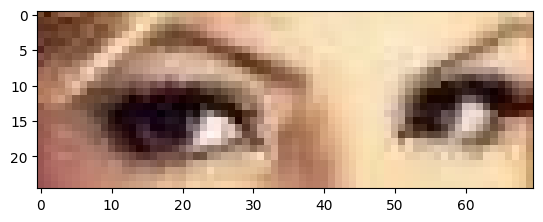

0.0
--------------------------------------------------


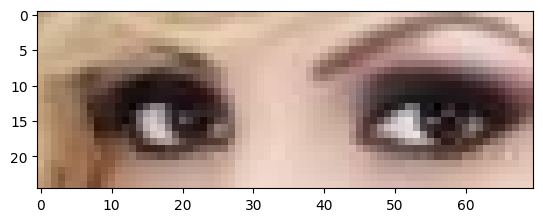

0.0
--------------------------------------------------


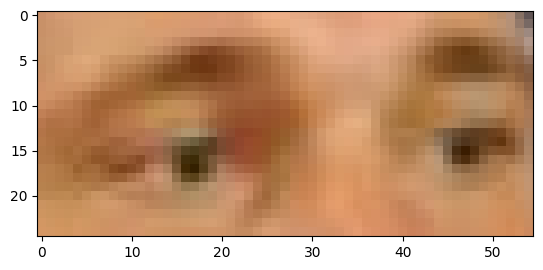

11.0


In [4]:
import matplotlib.pyplot as plt

eyes_list = []
# same
# plt.imshow(train_set[0][0])
eyes_list.append(train_set[0][0][35:60,15:85,:])
plt.imshow(eyes_list[0])
plt.show()
print(train_set[0][1])
print("-"*50)

# plt.imshow(train_set[1][0])
eyes_list.append(train_set[1][0][35:60,20:90,:])
plt.imshow(eyes_list[1])
plt.show()
print(train_set[1][1])
print("-"*50)

# diff
# plt.imshow(train_set[800][0])
eyes_list.append(train_set[800][0][35:60,20:75,:])
plt.imshow(eyes_list[2])
plt.show()
print(train_set[800][1])

[ 6.22857143  8.28571429  7.02857143  6.          4.51428571  4.
  8.05714286  6.8         3.48571429  2.34285714  2.22857143  4.45714286
  3.42857143 33.14285714]
(14,)


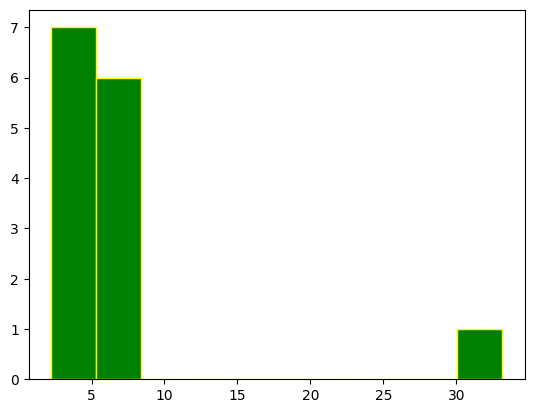

[ 5.82857143 10.11428571  6.51428571  4.4         2.34285714  3.2
 10.62857143  8.85714286  4.45714286  3.54285714  2.8         3.6
  2.51428571 31.2       ]
(14,)


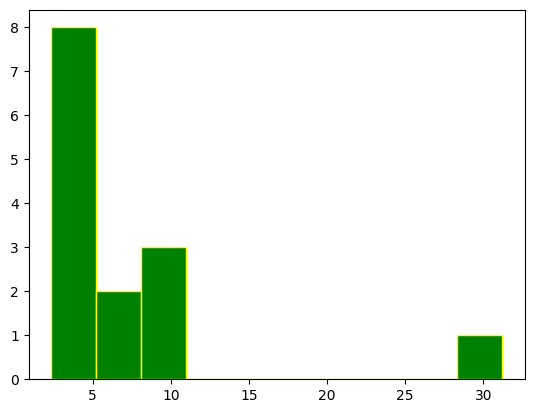

[ 7.56363636  8.58181818  7.34545454  4.87272727  3.92727273  4.07272727
  4.65454545  6.4         4.29090909  3.27272727  3.49090909  4.36363636
  4.         33.16363636]
(14,)


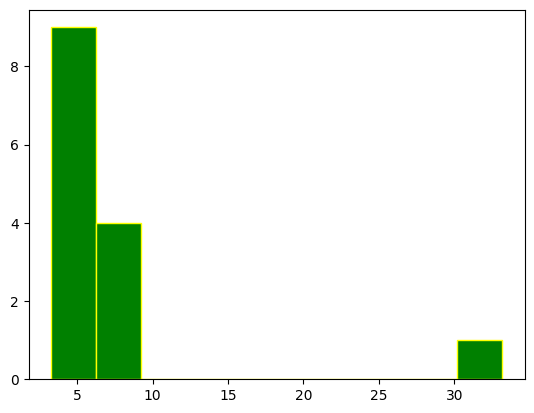

In [5]:
import cv2
desc = LocalBinaryPatterns(12, 4)

hist_list = []
gray = cv2.cvtColor(eyes_list[0], cv2.COLOR_BGR2GRAY)
hist_list.append(desc.describe(gray))
print(hist_list[0]*100)
print(hist_list[0].shape)
plt.hist(hist_list[0]*100, ec="yellow", fc="green")
plt.show()

gray = cv2.cvtColor(eyes_list[1], cv2.COLOR_BGR2GRAY)
hist_list.append(desc.describe(gray))
print(hist_list[1]*100)
print(hist_list[1].shape)
plt.hist(hist_list[1]*100, ec="yellow", fc="green")
plt.show()

gray = cv2.cvtColor(eyes_list[2], cv2.COLOR_BGR2GRAY)
hist_list.append(desc.describe(gray))
print(hist_list[2]*100)
print(hist_list[2].shape)
plt.hist(hist_list[2]*100, ec="yellow", fc="green")
plt.show()

In [6]:
x = np.array([1,2])
y = np.array([1,3])
print(x.dot(y))
# print(np.linalg.norm(x))

7


In [7]:
def np_cos_sim(x:np.array, y:np.array):
    return x.dot(y)/(np.linalg.norm(x)*np.linalg.norm(y))

def euclidean(x:np.array, y:np.array):
    return np.linalg.norm(x-y)

print(np_cos_sim(hist_list[0], hist_list[1]))
print(np_cos_sim(hist_list[0], hist_list[2]))
print(np_cos_sim(hist_list[1], hist_list[2]))
print()

print(euclidean(hist_list[0], hist_list[1]))
print(euclidean(hist_list[0], hist_list[2]))
print(euclidean(hist_list[1], hist_list[2]))

0.9897400426041923
0.9936955152382293
0.9800479419107272

0.05530176953711513
0.04332548505635827
0.07648274128283127


In [8]:
print(hist_list[0])

[0.06228571 0.08285714 0.07028571 0.06       0.04514286 0.04
 0.08057143 0.068      0.03485714 0.02342857 0.02228571 0.04457143
 0.03428571 0.33142857]


In [9]:
print(hist_list[1])

[0.05828571 0.10114286 0.06514286 0.044      0.02342857 0.032
 0.10628571 0.08857143 0.04457143 0.03542857 0.028      0.036
 0.02514286 0.312     ]


In [10]:
print(hist_list[2])

[0.07563636 0.08581818 0.07345455 0.04872727 0.03927273 0.04072727
 0.04654545 0.064      0.04290909 0.03272727 0.03490909 0.04363636
 0.04       0.33163636]


# ORB (Oriented FAST and Rotated BRIEF)
[explanation](https://medium.com/data-breach/introduction-to-orb-oriented-fast-and-rotated-brief-4220e8ec40cf)

In [12]:
eyes_list[0].shape

(25, 70, 3)

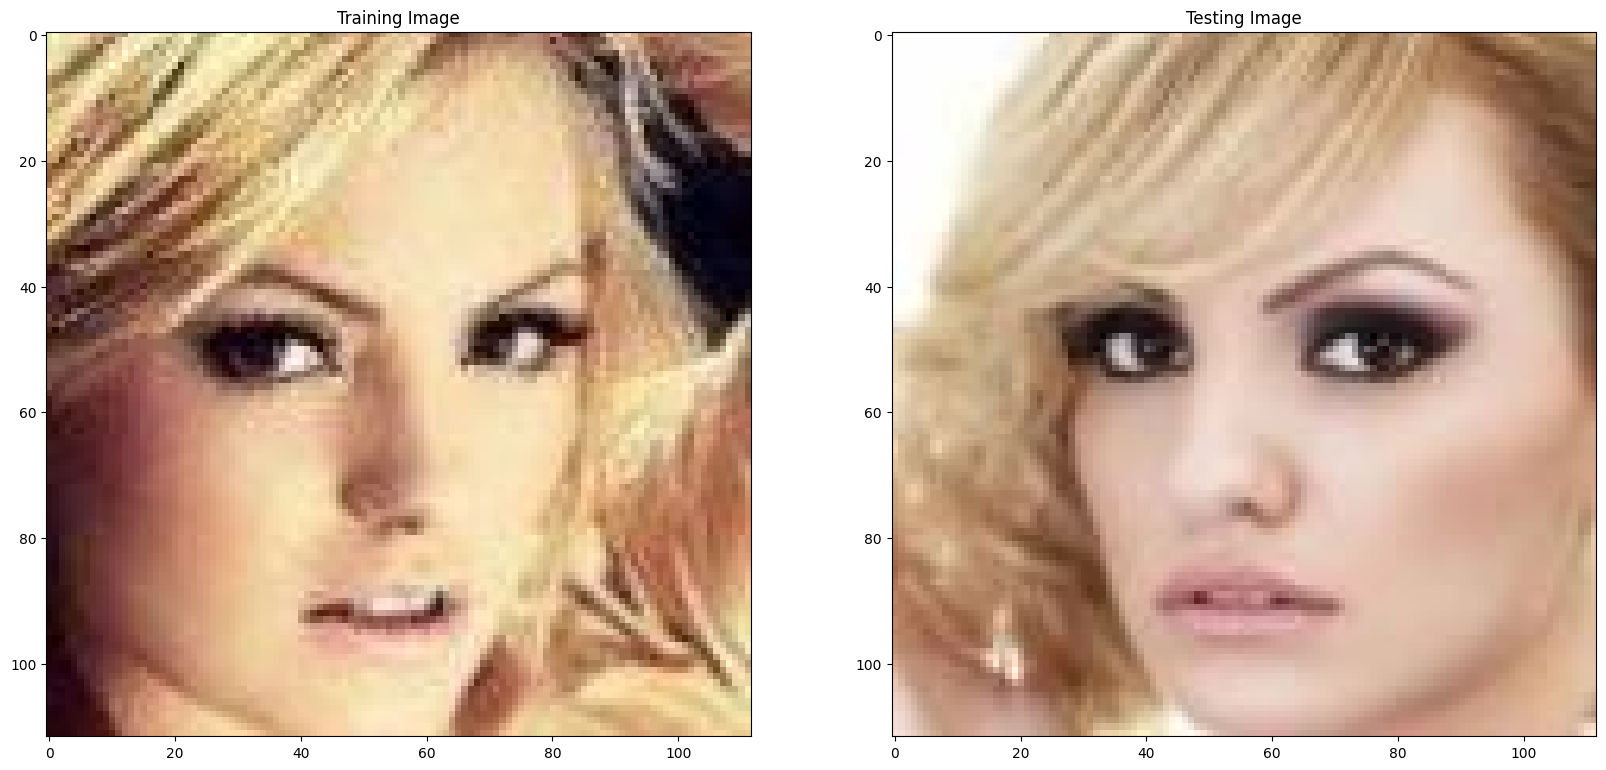

In [23]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load the image
# image1 = cv2.imread('./images/face1.jpeg')

# Convert the training image to RGB
# training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
training_image = train_set[0][0]

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)

# Create test image by adding Scale Invariance and Rotational Invariance
test_image = train_set[1][0]
# test_image = cv2.pyrDown(training_image)
# print(test_image.shape)
# plt.imshow(test_image)
# plt.show()
# test_image = cv2.pyrDown(test_image)
# print(test_image.shape)
# plt.imshow(test_image)
# plt.show()
num_rows, num_cols = test_image.shape[:2]

# rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 30, 1)
# test_image = cv2.warpAffine(test_image, rotation_matrix, (num_cols, num_rows))

test_gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

# Display traning image and testing image
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Training Image")
plots[0].imshow(training_image)

plots[1].set_title("Testing Image")
plots[1].imshow(test_image)

Number of Keypoints Detected In The Training Image:  64
Number of Keypoints Detected In The Query Image:  56


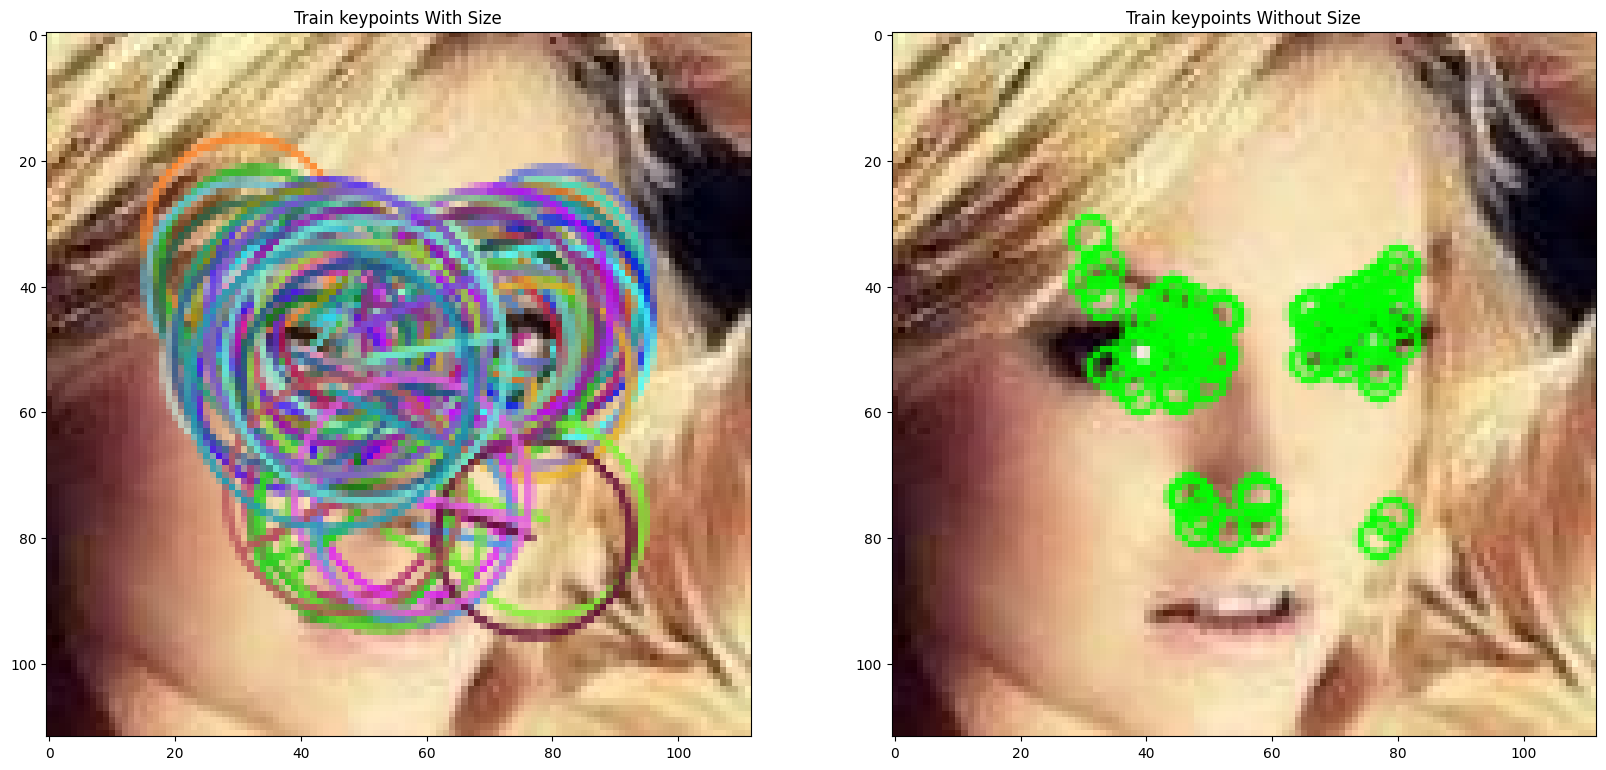

In [27]:
orb = cv2.ORB_create()

train_keypoints, train_descriptor = orb.detectAndCompute(training_gray, None)
test_keypoints, test_descriptor = orb.detectAndCompute(test_gray, None)

keypoints_without_size = np.copy(training_image)
keypoints_with_size = np.copy(training_image)

cv2.drawKeypoints(training_image, train_keypoints, keypoints_without_size, color = (0, 255, 0))

cv2.drawKeypoints(training_image, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))

In [30]:
print(type(train_keypoints))
print(type(test_keypoints))

<class 'list'>
<class 'list'>


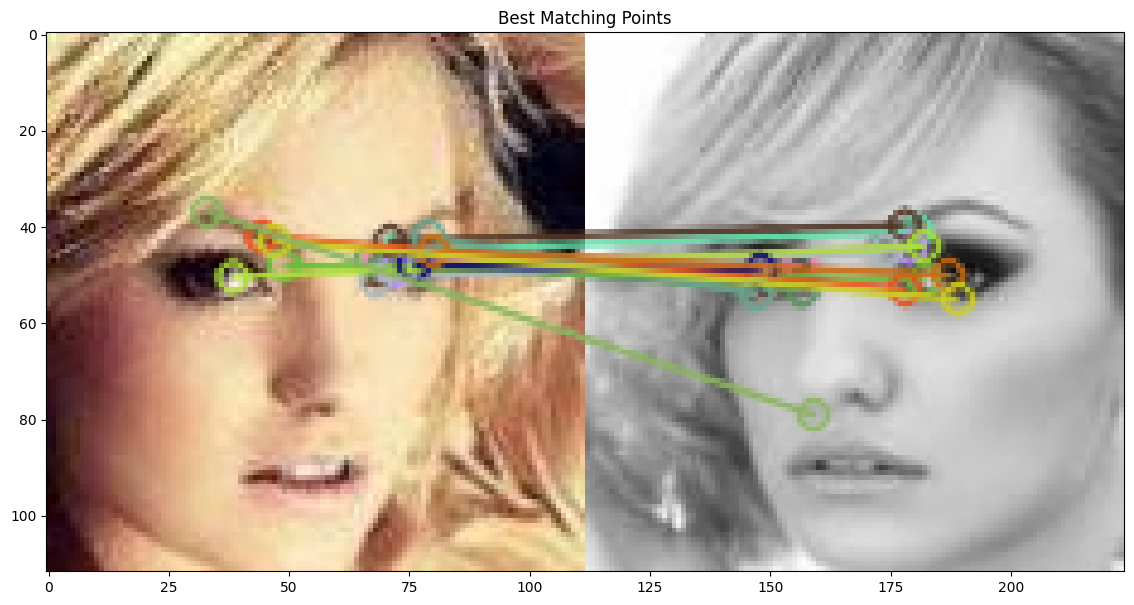


Number of Matching Keypoints Between The Training and Query Images:  15


In [25]:
# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Perform the matching between the ORB descriptors of the training image and the test image
matches = bf.match(train_descriptor, test_descriptor)

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(training_image, train_keypoints, test_gray, test_keypoints, matches, test_gray, flags = 2)

# Display the best matching points
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))


In [ ]:
import pickle
with open("./keypoints.pkl", "wb") as f:
    pickle.dump(train_keypoints)

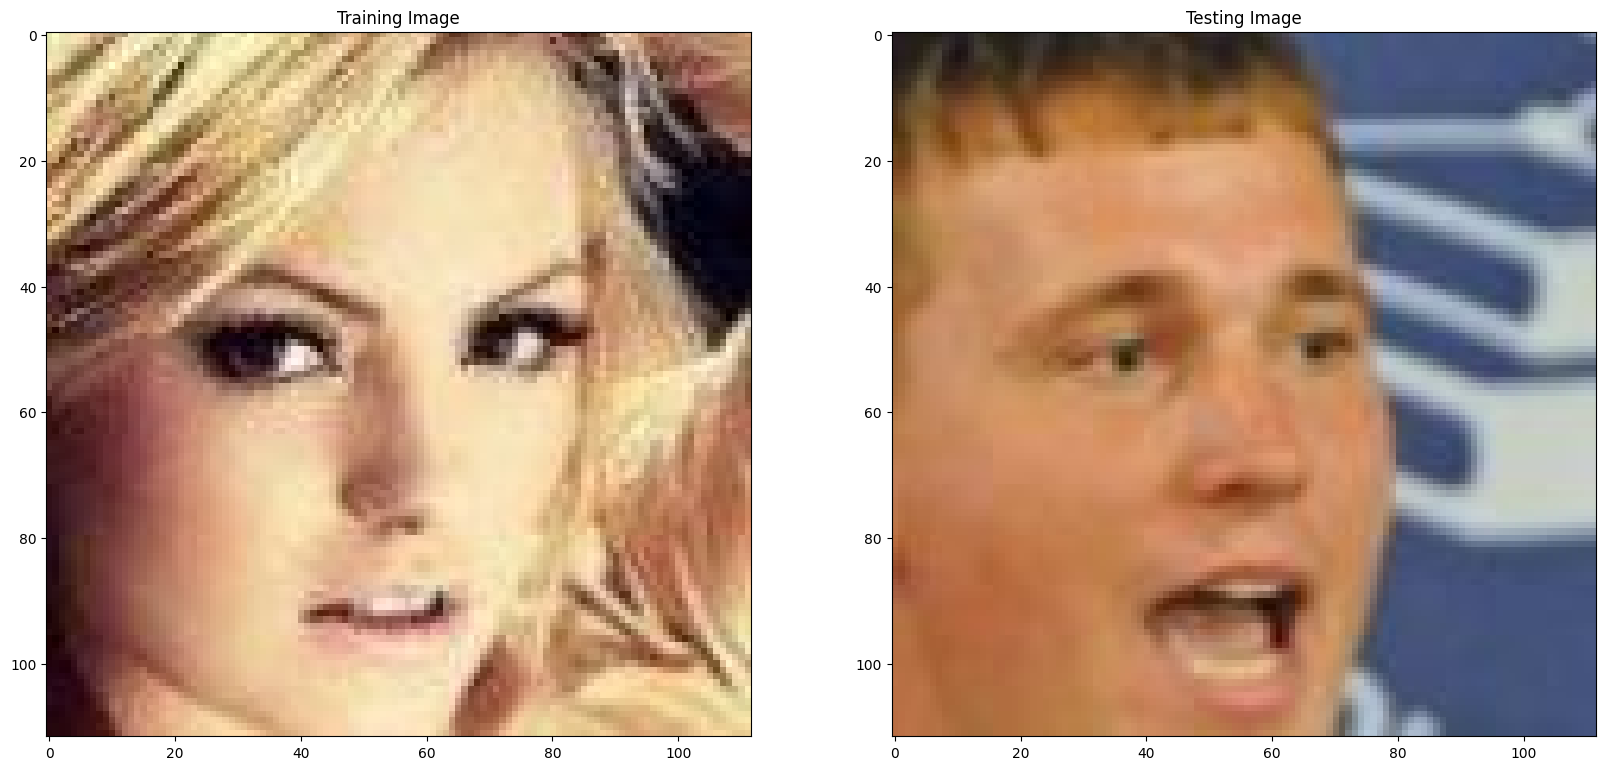

In [34]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load the image
# image1 = cv2.imread('./images/face1.jpeg')

# Convert the training image to RGB
# training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
training_image = train_set[0][0]

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)

# Create test image by adding Scale Invariance and Rotational Invariance
test_image = train_set[800][0]
# test_image = cv2.pyrDown(training_image)
# print(test_image.shape)
# plt.imshow(test_image)
# plt.show()
# test_image = cv2.pyrDown(test_image)
# print(test_image.shape)
# plt.imshow(test_image)
# plt.show()
num_rows, num_cols = test_image.shape[:2]

# rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 30, 1)
# test_image = cv2.warpAffine(test_image, rotation_matrix, (num_cols, num_rows))

test_gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

# Display traning image and testing image
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Training Image")
plots[0].imshow(training_image)

plots[1].set_title("Testing Image")
plots[1].imshow(test_image)

Number of Keypoints Detected In The Training Image:  64
Number of Keypoints Detected In The Query Image:  50


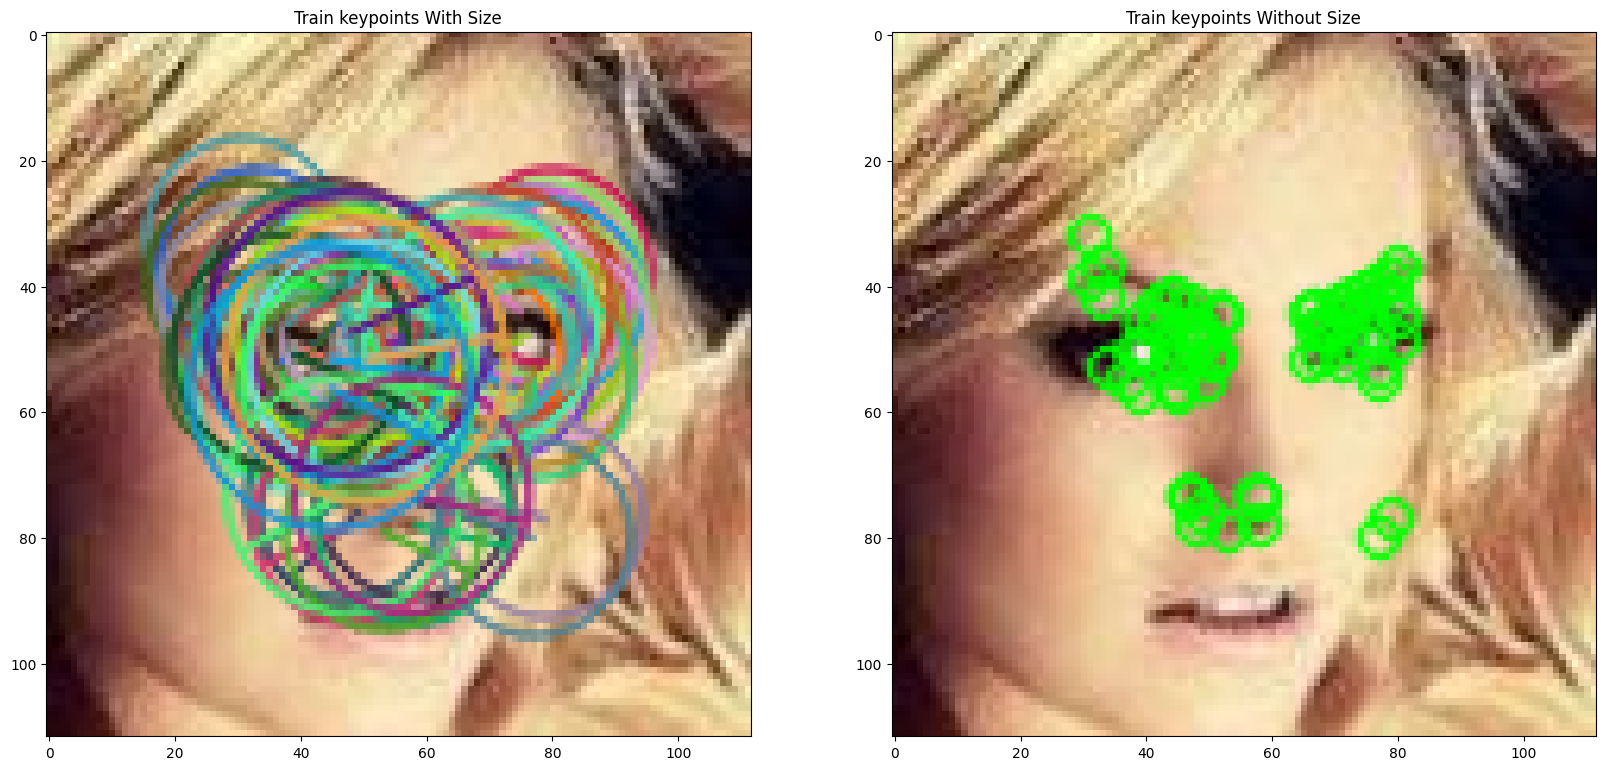

In [35]:
orb = cv2.ORB_create()

train_keypoints, train_descriptor = orb.detectAndCompute(training_gray, None)
test_keypoints, test_descriptor = orb.detectAndCompute(test_gray, None)

keypoints_without_size = np.copy(training_image)
keypoints_with_size = np.copy(training_image)

cv2.drawKeypoints(training_image, train_keypoints, keypoints_without_size, color = (0, 255, 0))

cv2.drawKeypoints(training_image, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))

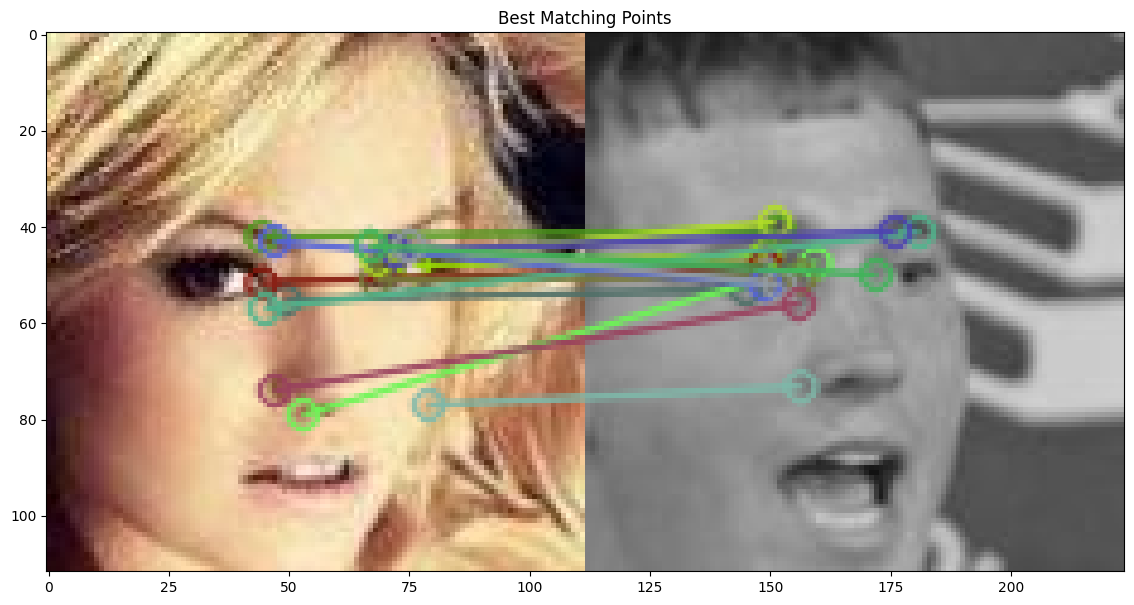


Number of Matching Keypoints Between The Training and Query Images:  14


In [36]:
# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Perform the matching between the ORB descriptors of the training image and the test image
matches = bf.match(train_descriptor, test_descriptor)

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(training_image, train_keypoints, test_gray, test_keypoints, matches, test_gray, flags = 2)

# Display the best matching points
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))


# ===================

params: 25,557,032
--------------------------------------------------
(363, 338, 3)


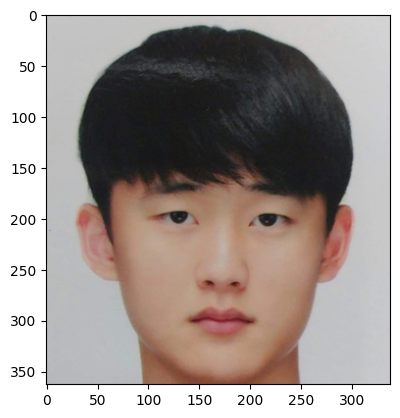

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


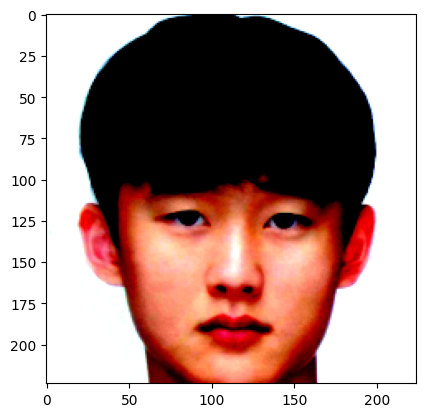

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


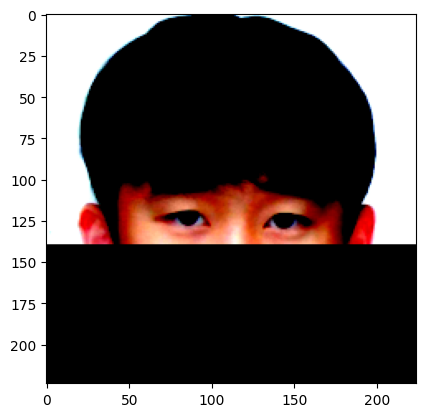

normal image shape: torch.Size([1, 3, 224, 224])
mask image shape: torch.Size([1, 3, 224, 224])
normal image output shape: torch.Size([1, 1000])
mask image output shape: torch.Size([1, 1000])
--------------------------------------------------
(3088, 2316, 3)


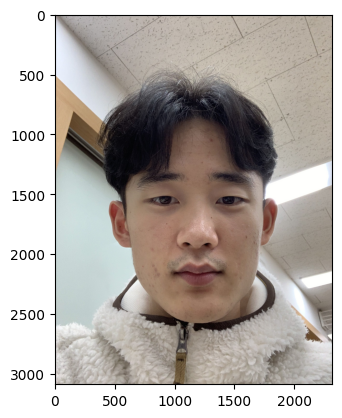

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


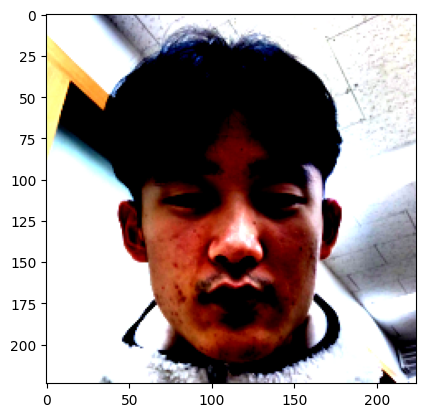

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


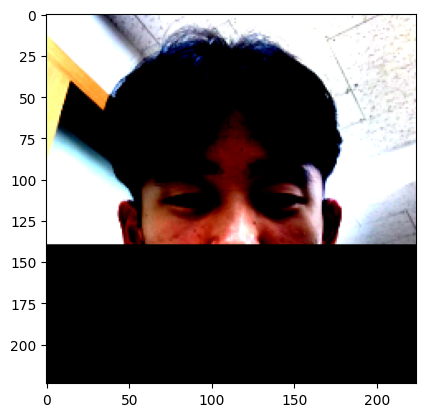

normal image shape: torch.Size([1, 3, 224, 224])
mask image shape: torch.Size([1, 3, 224, 224])
normal image output shape: torch.Size([1, 1000])
mask image output shape: torch.Size([1, 1000])
--------------------------------------------------
(273, 280, 3)


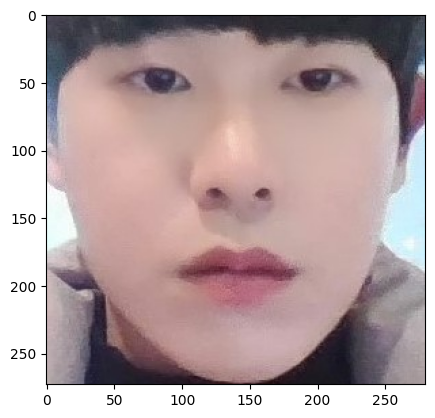

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


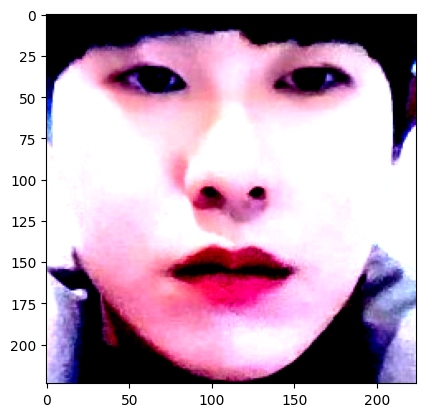

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


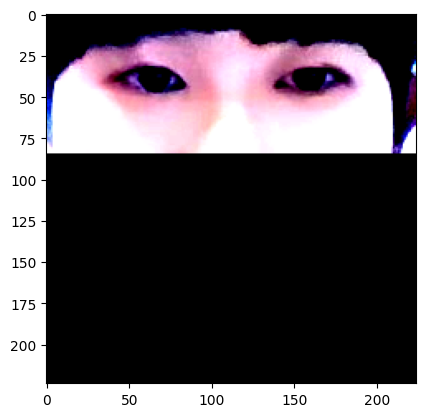

normal image shape: torch.Size([1, 3, 224, 224])
mask image shape: torch.Size([1, 3, 224, 224])
normal image output shape: torch.Size([1, 1000])
mask image output shape: torch.Size([1, 1000])
--------------------------------------------------
(616, 624, 3)


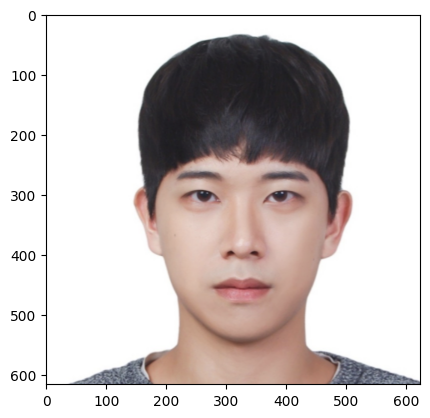

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


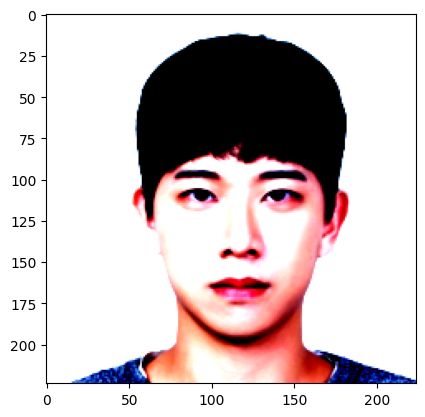

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


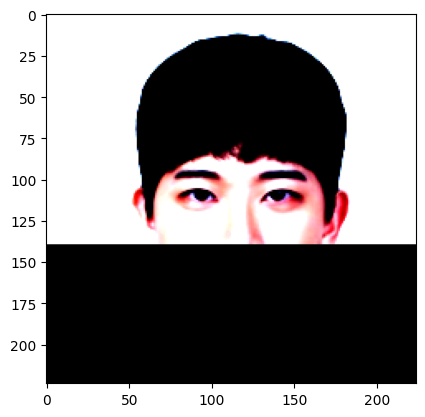

normal image shape: torch.Size([1, 3, 224, 224])
mask image shape: torch.Size([1, 3, 224, 224])
normal image output shape: torch.Size([1, 1000])
mask image output shape: torch.Size([1, 1000])


In [31]:
# Trained model with margin loss(ArcFace, CosFace, SphereFace)
import os
import torch
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torch import nn
from torchvision import transforms
from torchvision import models

base_dir = "/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/"

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.eval()
print("params: {:,}".format(sum([p.data.nelement() for p in model.parameters()])))

normal_vector_list = []
mask_vector_list = []
for i in range(4):
    print("-"*50)
    np_img = cv2.imread(os.path.join(base_dir,f"images/{i}.jpg"))
    np_img = cv2.cvtColor(np_img, cv2.COLOR_RGB2BGR)
    # np_img = np.array(img)
    if np_img.shape[-1] > 3:
        print("alpha channel remove")
        np_img = np_img[:,:,0:3]

    print(np_img.shape)
    plt.imshow(np_img)
    plt.show()

    min_size = min(np_img.shape[0:-1])
    image_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.CenterCrop((min_size,min_size)),
            transforms.Resize(size=(224,224)),
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406], 
                [0.229, 0.224, 0.225]
            )
        ])

    torch_img = image_transforms(np_img)
    C, H, W = torch_img.size()
    torch_img = torch_img.view(1,C,H,W)
    mask_img = torch_img.clone()
    if i==0 or i==1 or i==3:
        mask_img.view(C,H,W).permute(1,2,0)[140:225,:,:] = 0.0
    if i==2:
        mask_img.view(C,H,W).permute(1,2,0)[85:225,:,:] = 0.0
    plt.imshow(torch_img.view(C,H,W).permute(1,2,0))
    plt.show()
    plt.imshow(mask_img.view(C,H,W).permute(1,2,0))
    plt.show()
    print("normal image shape:", torch_img.shape)
    print("mask image shape:", mask_img.shape)
    
    with torch.no_grad():
        model.eval()
        output1 = model(torch_img)
        output2 = model(mask_img)
    print("normal image output shape:", output1.shape)
    print("mask image output shape:", output2.shape)
    normal_vector_list.append(output1)
    mask_vector_list.append(output2)

In [36]:
print(euclidean(normal_vector_list[0],normal_vector_list[1])) # same
print(euclidean(normal_vector_list[0],normal_vector_list[2]))
print(euclidean(normal_vector_list[0],normal_vector_list[3]))
# print(euclidean(normal_vector_list[0],normal_vector_list[4]))
print()
print(euclidean(normal_vector_list[2],normal_vector_list[3])) # same
# print(euclidean(normal_vector_list[2],normal_vector_list[4])) # same
print(euclidean(normal_vector_list[2],normal_vector_list[0]))
print(euclidean(normal_vector_list[2],normal_vector_list[1]))

tensor(450.1344)
tensor(393.4095)
tensor(299.7495)

tensor(385.9210)
tensor(393.4095)
tensor(421.2327)


In [37]:
print(euclidean(mask_vector_list[0],mask_vector_list[1])) # same
print(euclidean(mask_vector_list[0],mask_vector_list[2]))
print(euclidean(mask_vector_list[0],mask_vector_list[3]))
# print(euclidean(mask_vector_list[0],mask_vector_list[4]))
print()
print(euclidean(mask_vector_list[2],mask_vector_list[3])) # same
# print(euclidean(mask_vector_list[2],mask_vector_list[4])) # same
print(euclidean(mask_vector_list[2],mask_vector_list[0]))
print(euclidean(mask_vector_list[2],mask_vector_list[1]))

tensor(522.1247)
tensor(490.3907)
tensor(419.6050)

tensor(406.9105)
tensor(490.3907)
tensor(482.9297)


In [34]:
print(cos_sim(normal_vector_list[0],normal_vector_list[1])) # same
print(cos_sim(normal_vector_list[0],normal_vector_list[2]))
print(cos_sim(normal_vector_list[0],normal_vector_list[3]))
# print(cos_sim(normal_vector_list[0],normal_vector_list[4]))
print()
print(cos_sim(normal_vector_list[2],normal_vector_list[3])) # same
# print(cos_sim(normal_vector_list[2],normal_vector_list[4])) # same
print(cos_sim(normal_vector_list[2],normal_vector_list[0]))
print(cos_sim(normal_vector_list[2],normal_vector_list[1]))

tensor(0.6441)
tensor(0.7175)
tensor(0.8553)

tensor(0.7143)
tensor(0.7175)
tensor(0.6187)


In [35]:
print(cos_sim(mask_vector_list[0],mask_vector_list[1])) # same
print(cos_sim(mask_vector_list[0],mask_vector_list[2]))
print(cos_sim(mask_vector_list[0],mask_vector_list[3]))
# print(cos_sim(mask_vector_list[0],mask_vector_list[4]))
print()
print(cos_sim(mask_vector_list[2],mask_vector_list[3])) # same
# print(cos_sim(mask_vector_list[2],mask_vector_list[4])) # same
print(cos_sim(mask_vector_list[2],mask_vector_list[0]))
print(cos_sim(mask_vector_list[2],mask_vector_list[1]))

tensor(0.6281)
tensor(0.5621)
tensor(0.7470)

tensor(0.7817)
tensor(0.5621)
tensor(0.6399)


# Trained iresnet18 with arcface and MSMV12 dataset

params: 24,025,600
--------------------------------------------------
(363, 338, 3)


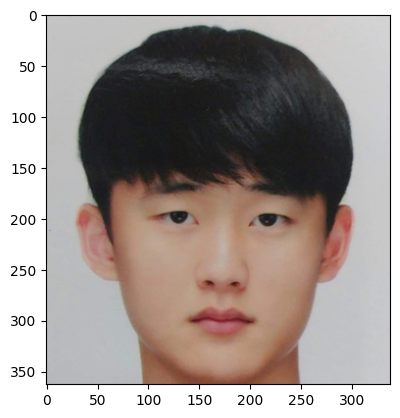

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


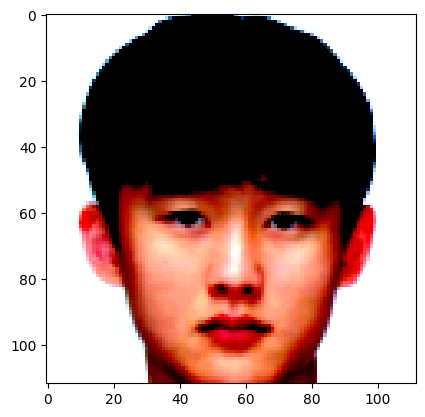

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


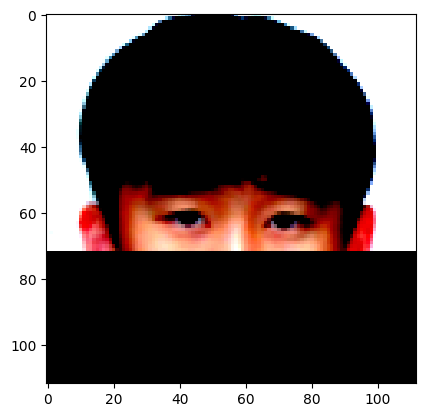

normal image shape: torch.Size([1, 3, 112, 112])
mask image shape: torch.Size([1, 3, 112, 112])
normal image output shape: torch.Size([1, 512])
mask image output shape: torch.Size([1, 512])
--------------------------------------------------
(3088, 2316, 3)


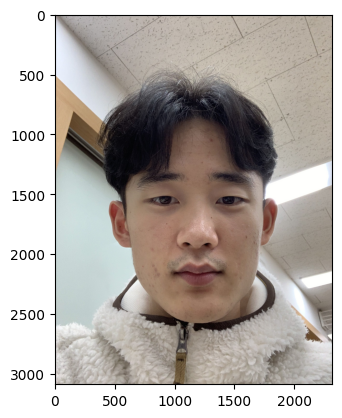

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


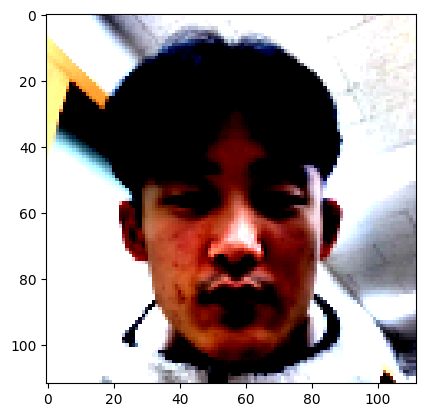

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


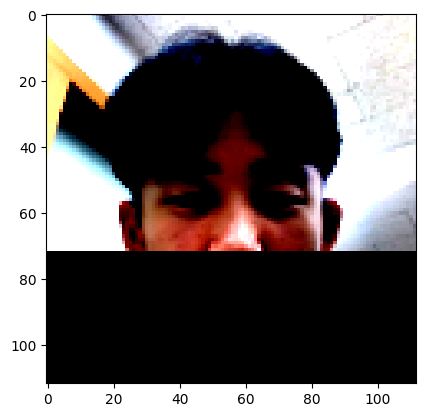

normal image shape: torch.Size([1, 3, 112, 112])
mask image shape: torch.Size([1, 3, 112, 112])
normal image output shape: torch.Size([1, 512])
mask image output shape: torch.Size([1, 512])
--------------------------------------------------
(273, 280, 3)


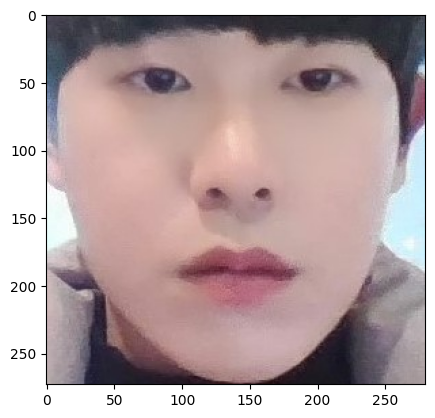

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


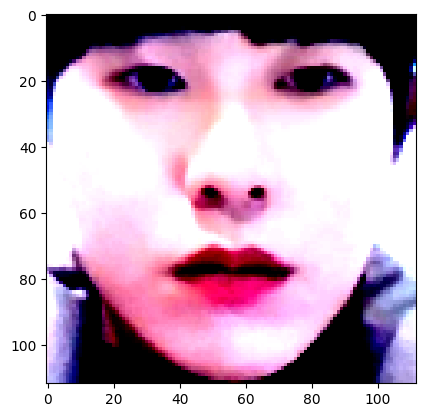

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


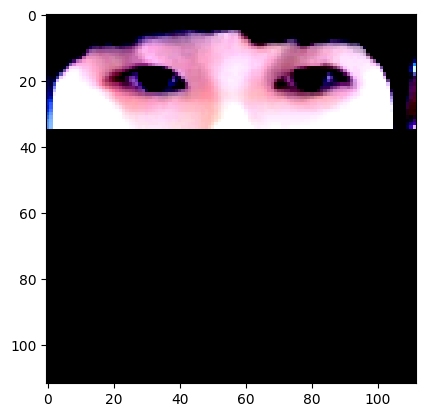

normal image shape: torch.Size([1, 3, 112, 112])
mask image shape: torch.Size([1, 3, 112, 112])
normal image output shape: torch.Size([1, 512])
mask image output shape: torch.Size([1, 512])
--------------------------------------------------
(616, 624, 3)


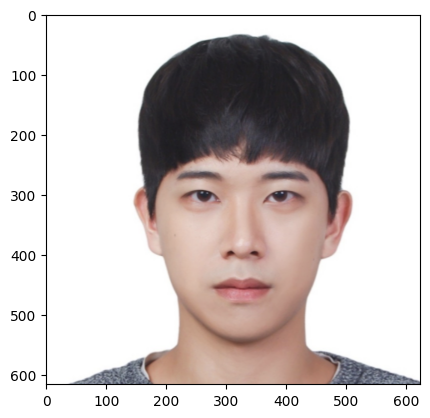

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


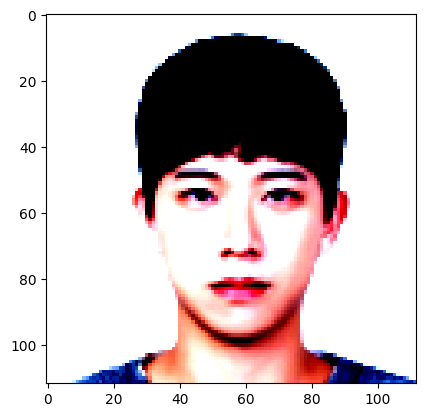

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


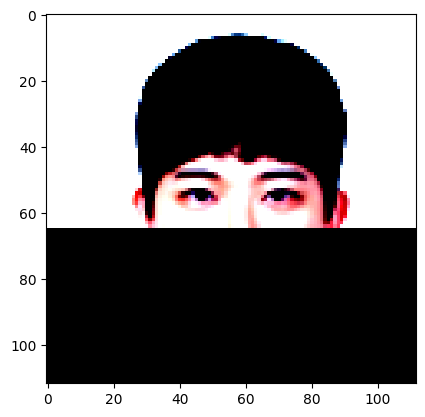

normal image shape: torch.Size([1, 3, 112, 112])
mask image shape: torch.Size([1, 3, 112, 112])
normal image output shape: torch.Size([1, 512])
mask image output shape: torch.Size([1, 512])


In [38]:
import os
import torch
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torch import nn
from torchvision import transforms
from model import get_model
from model.iresnet import iresnet18

base_dir = "/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/"

weights = torch.load(os.path.join(base_dir,"weights/backbone-r18.pth"), map_location=torch.device("cpu"))
model = iresnet18()
model.load_state_dict(weights)
model.eval()
print("params: {:,}".format(sum([p.data.nelement() for p in model.parameters()])))

normal_vector_list = []
mask_vector_list = []
for i in range(4):
    print("-"*50)
    np_img = cv2.imread(os.path.join(base_dir,f"images/{i}.jpg"))
    np_img = cv2.cvtColor(np_img, cv2.COLOR_RGB2BGR)
    # np_img = np.array(img)
    if np_img.shape[-1] > 3:
        print("alpha channel remove")
        np_img = np_img[:,:,0:3]

    print(np_img.shape)
    plt.imshow(np_img)
    plt.show()

    min_size = min(np_img.shape[0:-1])
    image_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.CenterCrop((min_size,min_size)),
            transforms.Resize(size=(112,112)), 
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406], 
                [0.229, 0.224, 0.225]
            )
        ])

    torch_img = image_transforms(np_img)
    C, H, W = torch_img.size()
    torch_img = torch_img.view(1,C,H,W)
    mask_img = torch_img.clone()
    if i==0 or i==1:
        mask_img.view(C,H,W).permute(1,2,0)[72:113,:,:] = 0.0
    if i==2:
        mask_img.view(C,H,W).permute(1,2,0)[35:113,:,:] = 0.0
    if i==3:
        mask_img.view(C,H,W).permute(1,2,0)[65:113,:,:] = 0.0
    plt.imshow(torch_img.view(C,H,W).permute(1,2,0))
    plt.show()
    plt.imshow(mask_img.view(C,H,W).permute(1,2,0))
    plt.show()
    print("normal image shape:", torch_img.shape)
    print("mask image shape:", mask_img.shape)
    
    with torch.no_grad():
        model.eval()
        output1 = model(torch_img)
        output2 = model(mask_img)
    print("normal image output shape:", output1.shape)
    print("mask image output shape:", output2.shape)
    normal_vector_list.append(output1)
    mask_vector_list.append(output2)

In [39]:
print(cos_sim(normal_vector_list[0],normal_vector_list[1])) # same
print(cos_sim(normal_vector_list[0],normal_vector_list[2]))
print(cos_sim(normal_vector_list[0],normal_vector_list[3]))
# print(cos_sim(normal_vector_list[0],normal_vector_list[4]))
print()
print(cos_sim(normal_vector_list[2],normal_vector_list[3])) # same
# print(cos_sim(normal_vector_list[2],normal_vector_list[4])) # same
print(cos_sim(normal_vector_list[2],normal_vector_list[0]))
print(cos_sim(normal_vector_list[2],normal_vector_list[1]))

tensor(0.4156)
tensor(0.0398)
tensor(0.0187)

tensor(0.2052)
tensor(0.0398)
tensor(-0.0621)


In [40]:
print(cos_sim(mask_vector_list[0],mask_vector_list[1])) # same
print(cos_sim(mask_vector_list[0],mask_vector_list[2]))
print(cos_sim(mask_vector_list[0],mask_vector_list[3]))
# print(cos_sim(mask_vector_list[0],mask_vector_list[4]))
print()
print(cos_sim(mask_vector_list[2],mask_vector_list[3])) # same
# print(cos_sim(mask_vector_list[2],mask_vector_list[4])) # same
print(cos_sim(mask_vector_list[2],mask_vector_list[0]))
print(cos_sim(mask_vector_list[2],mask_vector_list[1]))

tensor(0.4838)
tensor(0.3670)
tensor(0.3096)

tensor(0.2405)
tensor(0.3670)
tensor(0.2934)


# Trained model with every margin loss(ArcFace, CosFace, SphereFace)

params: 24,025,600
--------------------------------------------------
(363, 338, 3)


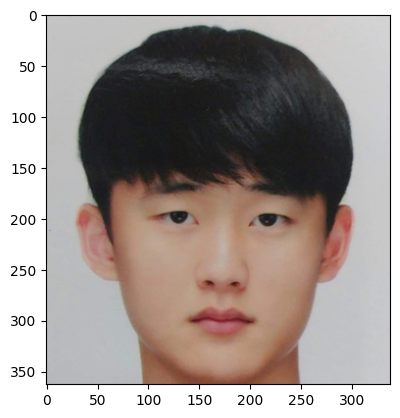

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


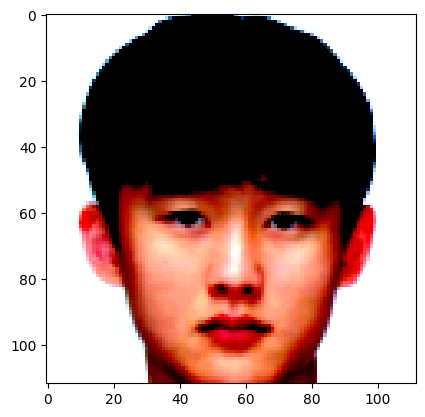

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


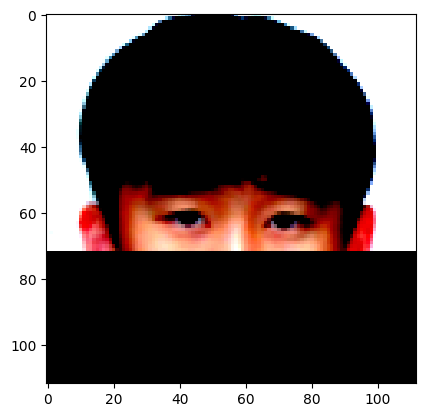

normal image shape: torch.Size([1, 3, 112, 112])
mask image shape: torch.Size([1, 3, 112, 112])
normal image output shape: torch.Size([1, 512])
mask image output shape: torch.Size([1, 512])
--------------------------------------------------
(3088, 2316, 3)


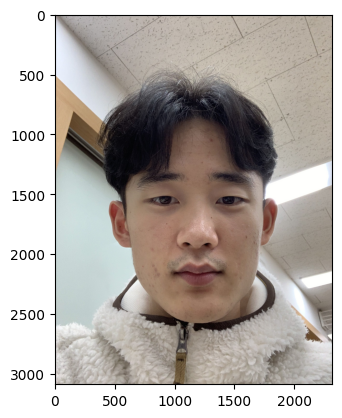

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


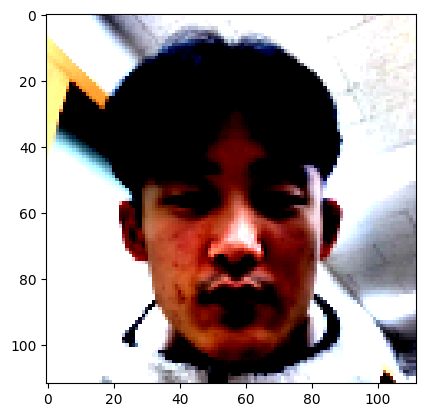

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


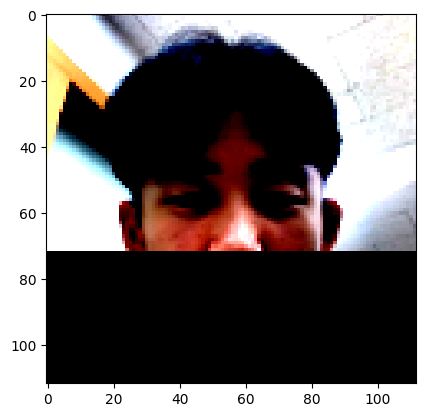

normal image shape: torch.Size([1, 3, 112, 112])
mask image shape: torch.Size([1, 3, 112, 112])
normal image output shape: torch.Size([1, 512])
mask image output shape: torch.Size([1, 512])
--------------------------------------------------
(273, 280, 3)


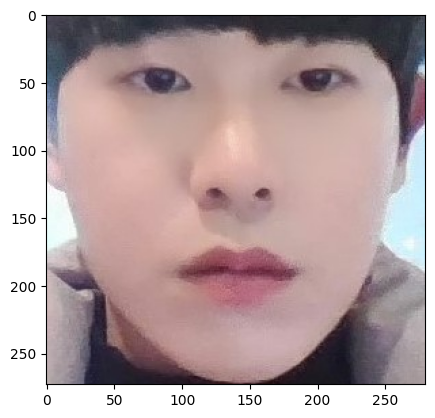

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


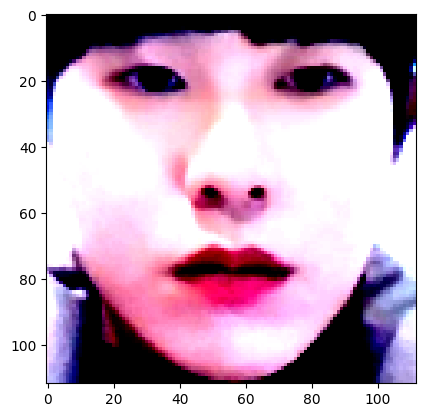

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


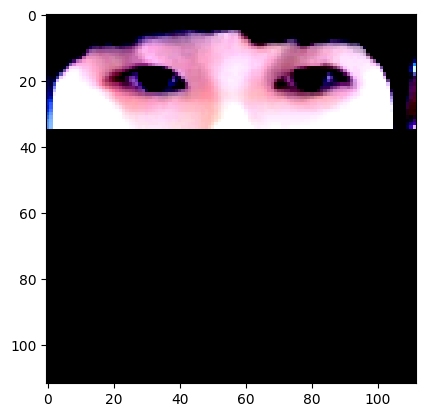

normal image shape: torch.Size([1, 3, 112, 112])
mask image shape: torch.Size([1, 3, 112, 112])
normal image output shape: torch.Size([1, 512])
mask image output shape: torch.Size([1, 512])
--------------------------------------------------
(616, 624, 3)


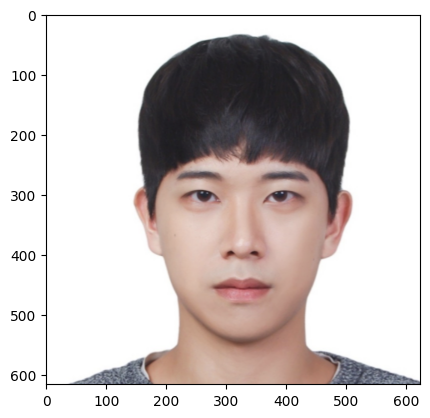

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


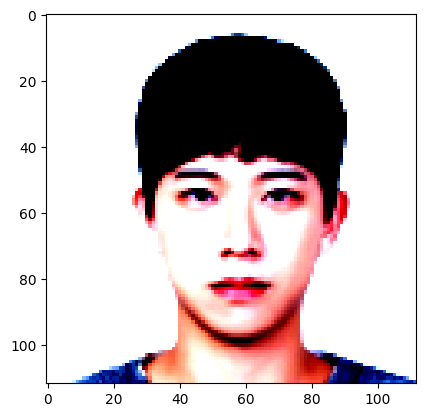

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


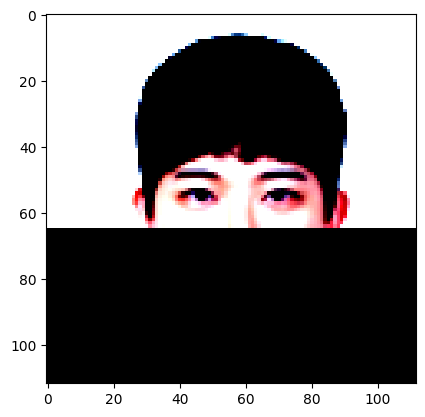

normal image shape: torch.Size([1, 3, 112, 112])
mask image shape: torch.Size([1, 3, 112, 112])
normal image output shape: torch.Size([1, 512])
mask image output shape: torch.Size([1, 512])


In [41]:
import os
import torch
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torch import nn
from torchvision import transforms
from model import get_model
from model.iresnet import iresnet18

base_dir = "/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/"

weights = torch.load(os.path.join(base_dir,"weights/backbone-every-margin-loss-r18.pth"), map_location=torch.device("cpu"))
model = iresnet18()
model.load_state_dict(weights)
model.eval()
print("params: {:,}".format(sum([p.data.nelement() for p in model.parameters()])))

normal_vector_list = []
mask_vector_list = []
for i in range(4):
    print("-"*50)
    np_img = cv2.imread(os.path.join(base_dir,f"images/{i}.jpg"))
    np_img = cv2.cvtColor(np_img, cv2.COLOR_RGB2BGR)
    # np_img = np.array(img)
    if np_img.shape[-1] > 3:
        print("alpha channel remove")
        np_img = np_img[:,:,0:3]

    print(np_img.shape)
    plt.imshow(np_img)
    plt.show()

    min_size = min(np_img.shape[0:-1])
    image_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.CenterCrop((min_size,min_size)),
            transforms.Resize(size=(112,112)), 
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406], 
                [0.229, 0.224, 0.225]
            )
        ])

    torch_img = image_transforms(np_img)
    C, H, W = torch_img.size()
    torch_img = torch_img.view(1,C,H,W)
    mask_img = torch_img.clone()
    if i==0 or i==1:
        mask_img.view(C,H,W).permute(1,2,0)[72:113,:,:] = 0.0
    if i==2:
        mask_img.view(C,H,W).permute(1,2,0)[35:113,:,:] = 0.0
    if i==3:
        mask_img.view(C,H,W).permute(1,2,0)[65:113,:,:] = 0.0
    plt.imshow(torch_img.view(C,H,W).permute(1,2,0))
    plt.show()
    plt.imshow(mask_img.view(C,H,W).permute(1,2,0))
    plt.show()
    print("normal image shape:", torch_img.shape)
    print("mask image shape:", mask_img.shape)
    
    with torch.no_grad():
        model.eval()
        output1 = model(torch_img)
        output2 = model(mask_img)
    print("normal image output shape:", output1.shape)
    print("mask image output shape:", output2.shape)
    normal_vector_list.append(output1)
    mask_vector_list.append(output2)

In [ ]:
print(cos_sim(normal_vector_list[0],normal_vector_list[1])) # same
print(cos_sim(normal_vector_list[0],normal_vector_list[2]))
print(cos_sim(normal_vector_list[0],normal_vector_list[3]))
# print(cos_sim(normal_vector_list[0],normal_vector_list[4]))
print()
print(cos_sim(normal_vector_list[2],normal_vector_list[3])) # same
# print(cos_sim(normal_vector_list[2],normal_vector_list[4])) # same
print(cos_sim(normal_vector_list[2],normal_vector_list[0]))
print(cos_sim(normal_vector_list[2],normal_vector_list[1]))

In [ ]:
print(cos_sim(mask_vector_list[0],mask_vector_list[1])) # same
print(cos_sim(mask_vector_list[0],mask_vector_list[2]))
print(cos_sim(mask_vector_list[0],mask_vector_list[3]))
# print(cos_sim(mask_vector_list[0],mask_vector_list[4]))
print()
print(cos_sim(mask_vector_list[2],mask_vector_list[3])) # same
# print(cos_sim(mask_vector_list[2],mask_vector_list[4])) # same
print(cos_sim(mask_vector_list[2],mask_vector_list[0]))
print(cos_sim(mask_vector_list[2],mask_vector_list[1]))

# Any Test

In [9]:
# print(torch.pow(torch.tensor([4,2]),2))
# print(torch.sqrt(torch.tensor([4,2])))
# print(torch.tensor([4,2]).sum())
x = torch.tensor([[1.,2.]])
y = torch.tensor([[2.,2.]])
print(cos_sim(x,y))
print(cos_sim(y,x))
print()
print(y.view(-1).shape)
print(x@y.T)
print(x.view(-1).dot(y.view(-1)))
print(torch.norm(x))
print(torch.norm(y))
print()
print(x.view(-1).dot(y.view(-1))/(torch.norm(y)*torch.norm(x)))

tensor(0.9487)
tensor(0.9487)

torch.Size([2])
tensor([[6.]])
tensor(6.)
tensor(2.2361)
tensor(2.8284)

tensor(0.9487)


In [72]:
x = torch.tensor([1.,2.])
y = torch.tensor([2.,2.])
print(x@y.T)
print(x.dot(y))

tensor(6.)
tensor(6.)


In [81]:
from torchvision import models
# model = models.resnet18(models.ResNet18_Weights.DEFAULT)
# print("params: {:,}".format(sum([p.data.nelement() for p in model.parameters()])))
# x = torch.randn((3,3,224,224))
x = np.random.random((3,3,224,224))
print(torch.from_numpy(x).shape)
# print(model)

torch.Size([3, 3, 224, 224])


In [24]:
print(np_img.shape)
print(max(np_img.shape))

(3088, 2316, 3)
3088


In [22]:
import torch
check = torch.load("/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/weights/baseline-arcface.pth")
print(type(check))

<class 'collections.OrderedDict'>
